In [3]:
import numpy as np

VIT_PATH = '/home/maria/ProjectionSort/data/google_vit-base-patch16-224_embeddings_logits.pkl'
NEURAL_PATH = '/home/maria/ProjectionSort/data/hybrid_neural_responses_reduced.npy'
AREAS_PATH = '/home/maria/ProjectionSort/data/brain_area.npy'  


# Load data
vit = np.load(VIT_PATH, allow_pickle=True)['natural_scenes']
R = np.load(NEURAL_PATH)            # shape: (images, neurons)
areas = np.load(AREAS_PATH, allow_pickle=True)         # shape: (neurons,)
# vit: (n_images, 1000)
# R:   (n_images, n_neurons)

pos_classes = [
    291, 274, 288, 293, 271, 292, 290, 272, 269, 280,
    286, 275, 276, 294, 289, 273, 270, 287, 278, 371,
]

neg_classes = [
    421, 879, 412, 716, 703, 637, 818, 883, 489, 898,
    880, 733, 706, 523, 738, 616, 448, 696, 704, 506,
]

animal_set = set(pos_classes)  # “predator-ish” classes

top1 = np.argmax(vit, axis=1)  # top-1 ImageNet class per image

# Binary semantic feature: 1 = animal-ish, 0 = non-animal-ish
animal_feat = np.isin(top1, list(animal_set)).astype(float)   # shape: (n_images,)

neuron_idx = 20
y = R[neuron_idx,:]   # neural average event probs for each image

animal_mask = animal_feat == 1
non_mask    = animal_feat == 0

mu_animal = y[animal_mask].mean()
mu_non    = y[non_mask].mean()
effect    = mu_animal - mu_non

print("Neuron", neuron_idx)
print("mean response on animal images:    ", mu_animal)
print("mean response on non-animal images:", mu_non)
print("difference (animal - non-animal):  ", effect)


Neuron 20
mean response on animal images:     0.08
mean response on non-animal images: 0.030099009900990098
difference (animal - non-animal):   0.049900990099009904


In [4]:
from sklearn.linear_model import LinearRegression

X = animal_feat.reshape(-1, 1)  # column vector (n_images, 1)
reg = LinearRegression().fit(X, y)
print("slope (animal effect):", reg.coef_[0])
print("intercept:", reg.intercept_)


slope (animal effect): 0.049900990099009924
intercept: 0.030099009900990098


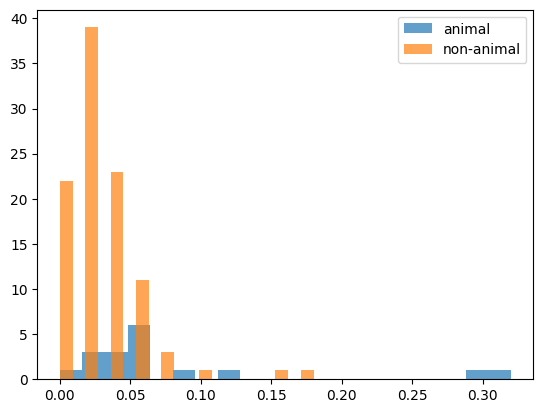

In [5]:
import matplotlib.pyplot as plt

plt.hist(y[animal_mask], bins=20, alpha=0.7, label="animal")
plt.hist(y[non_mask], bins=20, alpha=0.7, label="non-animal")
plt.legend()
plt.show()


In [8]:
import numpy as np
import requests
import json

# ============================================================
# 1. Paths
# ============================================================
VIT_PATH = "/home/maria/ProjectionSort/data/google_vit-base-patch16-224_embeddings_logits.pkl"

# ============================================================
# 2. Load ViT logits
# ============================================================
vit = np.load(VIT_PATH, allow_pickle=True)["natural_scenes"]   # (n_images, 1000)
n_images, n_classes = vit.shape
print("Loaded logits:", vit.shape)

# ============================================================
# 3. Download ImageNet 1k class labels
# ============================================================
URL = "https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json"
resp = requests.get(URL)
resp.raise_for_status()
class_idx = resp.json()   # { "0": ["n01440764", "tench"], ... }

# index → human-readable label
idx_to_label = {int(k): v[1] for k, v in class_idx.items()}

print("Loaded ImageNet labels:", len(idx_to_label))

# ============================================================
# 4. Compute top-1 ImageNet predictions for ALL images
# ============================================================
top1_indices = np.argmax(vit, axis=1)    # shape (n_images,)
top1_labels  = [idx_to_label[int(i)] for i in top1_indices]

print("Example predictions:")
for i in range(5):
    print(f"Image {i}: {top1_indices[i]} → {top1_labels[i]}")

# ============================================================
# 5. Build ANIMATE / INANIMATE classification over ALL 1000 classes
# ============================================================
# Animate classes in ImageNet:
# Standard practice: all classes 0–390 are animals (grouped by WordNet synsets)
# But we want a RELIABLE definition, so let's use WordNet categories.

import nltk
from nltk.corpus import wordnet as wn

# Make sure WordNet is downloaded
try:
    wn.synsets("cat")
except:
    nltk.download("wordnet")

def is_animate_class(label):
    """
    Returns True if the ImageNet class is an animal.
    WordNet-based check: if it has hypernyms 'animal', 'vertebrate', 'mammal', 'bird', etc.
    """
    syns = wn.synsets(label.replace(" ", "_"))  # WordNet names use underscores
    if len(syns) == 0:
        return False

    syn = syns[0]  # take primary sense
    # check ancestry in WordNet tree for 'animal' or any animal superclass
    animal_keywords = ["animal", "vertebrate", "mammal", "reptile", "amphibian", "bird", "fish", "arthropod"]
    hypernyms = syn.closure(lambda s: s.hypernyms())

    for h in hypernyms:
        name = h.name().split(".")[0].lower()
        if any(key in name for key in animal_keywords):
            return True

    return False

# Compute animate/inanimate for ALL 1000 ImageNet classes
animate_mask = np.array([is_animate_class(idx_to_label[i]) for i in range(1000)])

print("Total animate classes detected:", animate_mask.sum())
print("Total inanimate classes:", (~animate_mask).sum())

# ============================================================
# 6. Now classify each image as animate / inanimate
# ============================================================
image_is_animate = animate_mask[top1_indices]   # shape (n_images,), bool

print("Example:")
for i in range(10):
    print(f"Image {i:>3d}: {top1_labels[i]:<20} → animate={image_is_animate[i]}")


Loaded logits: (118, 1000)
Loaded ImageNet labels: 1000
Example predictions:
Image 0: 294 → brown_bear
Image 1: 294 → brown_bear
Image 2: 294 → brown_bear
Image 3: 35 → mud_turtle
Image 4: 146 → albatross


[nltk_data] Downloading package wordnet to /home/maria/nltk_data...


Total animate classes detected: 360
Total inanimate classes: 640
Example:
Image   0: brown_bear           → animate=True
Image   1: brown_bear           → animate=True
Image   2: brown_bear           → animate=True
Image   3: mud_turtle           → animate=True
Image   4: albatross            → animate=False
Image   5: lion                 → animate=True
Image   6: lion                 → animate=True
Image   7: lion                 → animate=True
Image   8: tusker               → animate=True
Image   9: tusker               → animate=True


In [10]:
top1 = np.argmax(vit, axis=1)  # (n_images,)

image_is_animal = (top1 <= 397).astype(float)

n_animal = image_is_animal.sum()
n_total = len(image_is_animal)
print(f"{n_animal} / {n_total} images are animal-predicted")



63.0 / 118 images are animal-predicted


In [12]:
neuron_idx = 20
y = R[neuron_idx,:]

animal_mask = image_is_animal == 1
non_mask = image_is_animal == 0

mu_animal = y[animal_mask].mean()
mu_non    = y[non_mask].mean()
diff = mu_animal - mu_non

print(mu_animal, mu_non, diff)

0.04412698412698413 0.029454545454545455 0.014672438672438677


In [14]:
import numpy as np

# vit: (n_images, 1000)
# R:   (n_images, n_neurons)

# Step 1 — top-1 predictions using your ViT logits
top1 = np.argmax(vit, axis=1)

# Step 2 — ImageNet ordering: 0–397 are animals
image_is_animal = (top1 <= 397).astype(bool)

# Step 3 — compute Δ_n for each neuron
n_neurons = R.shape[0]
animal_selectivity = np.zeros(n_neurons)

for n in range(n_neurons):
    y = R[n,:]
    mu_animal = y[image_is_animal].mean()
    mu_non    = y[~image_is_animal].mean()
    animal_selectivity[n] = mu_animal - mu_non

# Step 4 — summary
print("Selectivity vector shape:", animal_selectivity.shape)
print("Example (first 10):", animal_selectivity[:10])

# Optional: count how many neurons prefer animals vs non-animals
num_animal_pref = np.sum(animal_selectivity > 0)
num_object_pref = np.sum(animal_selectivity < 0)

print("Neurons preferring animals:", num_animal_pref)
print("Neurons preferring objects:", num_object_pref)


Selectivity vector shape: (39209,)
Example (first 10): [ 0.00262626  0.00063492  0.01094949 -0.00723232  0.00918326  0.00995671
  0.00197403 -0.01560173  0.01108802  0.00985859]
Neurons preferring animals: 25713
Neurons preferring objects: 13490


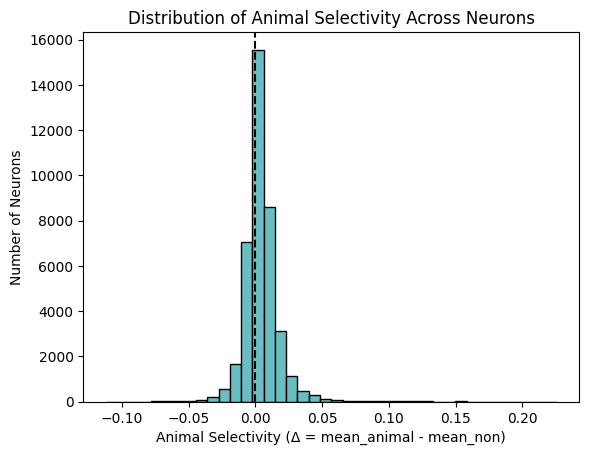

In [15]:
import matplotlib.pyplot as plt

plt.hist(animal_selectivity, bins=40, color="#6bbdc4", edgecolor="black")
plt.axvline(0, color="black", linestyle="--")
plt.xlabel("Animal Selectivity (Δ = mean_animal - mean_non)")
plt.ylabel("Number of Neurons")
plt.title("Distribution of Animal Selectivity Across Neurons")
plt.show()


In [16]:
areas_unique = np.unique(areas)

for a in areas_unique:
    mask = (areas == a)
    sel = animal_selectivity[mask]
    print(a, " mean selectivity:", np.mean(sel))


VISal  mean selectivity: 0.003180464837325274
VISam  mean selectivity: 0.0029592479416008814
VISl  mean selectivity: 0.005204959431079819
VISp  mean selectivity: 0.005510842778260382
VISpm  mean selectivity: 0.0031213098134079045
VISrl  mean selectivity: 0.0017511941075497276


In [19]:
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix

# ----------------------------------------------------------
# 1. Data loading
# ----------------------------------------------------------

# R: (neurons, images)  -> transpose to (images, neurons)
X = R.T.astype(float)                     # shape (n_images, n_neurons)

# Compute top-1 ImageNet classes for each image
top1 = np.argmax(vit, axis=1)             # shape (n_images,)

# Animate = classes 0–397
y = (top1 <= 397).astype(int)             # labels (0 = inanimate, 1 = animate)

print("X shape:", X.shape)
print("y shape:", y.shape)
print("Proportion animate:", y.mean())
print("Total images:", len(y))

# ----------------------------------------------------------
# 2. Stratified 10-fold CV
# ----------------------------------------------------------

kf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

accuracies = []
fold = 1

for train_index, test_index in kf.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Very important for high-dimensional data:
    # use 'liblinear' or 'saga' and strong L2 regularization
    clf = LogisticRegression(
        penalty='l2',
        C=1.0,
        solver='liblinear',
        max_iter=500
    )

    clf.fit(X_train, y_train)
    preds = clf.predict(X_test)

    acc = accuracy_score(y_test, preds)
    accuracies.append(acc)

    print(f"Fold {fold} accuracy: {acc:.4f}")
    fold += 1

# ----------------------------------------------------------
# 3. Results
# ----------------------------------------------------------

print("\n===============================")
print("Mean accuracy:", np.mean(accuracies))
print("Std accuracy:", np.std(accuracies))
print("===============================")

# ----------------------------------------------------------
# 4. Confusion matrix on the final fold
# ----------------------------------------------------------

cm = confusion_matrix(y_test, preds)
print("Confusion matrix (final fold):")
print(cm)


X shape: (118, 39209)
y shape: (118,)
Proportion animate: 0.5338983050847458
Total images: 118
Fold 1 accuracy: 0.7750
Fold 2 accuracy: 0.6923
Fold 3 accuracy: 0.7179

Mean accuracy: 0.7284188034188035
Std accuracy: 0.03456126401221455
Confusion matrix (final fold):
[[14  4]
 [ 7 14]]


In [20]:
import numpy as np
from sklearn.model_selection import LeaveOneOut
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix

# ----------------------------------------------------------
# 1. Prepare data
# ----------------------------------------------------------
# R: (neurons, images) -> (images, neurons)
X = R.T.astype(float)                     # (118, 39209)

# labels from ViT top-1
top1 = np.argmax(vit, axis=1)            # (118,)
y = (top1 <= 397).astype(int)            # 1 = animal, 0 = inanimate

print("X shape:", X.shape)
print("y shape:", y.shape,
      " | proportion animal:", y.mean())

# ----------------------------------------------------------
# 2. Leave-One-Out CV
# ----------------------------------------------------------
loo = LeaveOneOut()
y_true = []
y_pred = []

# single model per split (heavy but fine for 118 images)
for train_idx, test_idx in loo.split(X, y):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    clf = LogisticRegression(
        penalty='l2',
        C=0.1,              # stronger regularization (many features, few samples)
        solver='liblinear',
        max_iter=500
    )
    clf.fit(X_train, y_train)
    y_hat = clf.predict(X_test)

    y_true.append(y_test[0])
    y_pred.append(y_hat[0])

y_true = np.array(y_true)
y_pred = np.array(y_pred)

# ----------------------------------------------------------
# 3. Performance
# ----------------------------------------------------------
acc = accuracy_score(y_true, y_pred)
cm = confusion_matrix(y_true, y_pred)

print("\nLeave-One-Out accuracy:", acc)
print("Confusion matrix:")
print(cm)


X shape: (118, 39209)
y shape: (118,)  | proportion animal: 0.5338983050847458

Leave-One-Out accuracy: 0.7203389830508474
Confusion matrix:
[[38 17]
 [16 47]]


In [21]:
import numpy as np
from sklearn.model_selection import LeaveOneOut
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix

# ----------------------------------------------------------
# 1. Prepare labels
# ----------------------------------------------------------
top1 = np.argmax(vit, axis=1)
y = (top1 <= 397).astype(int)          # 1 = animal
X_full = R.T.astype(float)             # (images, neurons)

unique_areas = np.unique(areas)
print("Areas:", unique_areas)

# ----------------------------------------------------------
# 2. Leave-One-Out decoding per area
# ----------------------------------------------------------
results = {}

for area in unique_areas:
    print("\n======================")
    print(f"Decoding for area: {area}")
    print("======================")

    # pick neurons from this area
    mask = (areas == area)
    X_area = X_full[:, mask]           # (images, n_area_neurons)

    print(f"Neurons in {area}: {X_area.shape[1]}")

    if X_area.shape[1] < 5:
        print(f"Skipping {area} (too few neurons)")
        continue

    loo = LeaveOneOut()
    y_true = []
    y_pred = []

    for train_idx, test_idx in loo.split(X_area, y):
        X_train, X_test = X_area[train_idx], X_area[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        clf = LogisticRegression(
            penalty='l2',
            C=0.1,
            solver='liblinear',
            max_iter=500
        )
        clf.fit(X_train, y_train)
        pred = clf.predict(X_test)

        y_true.append(y_test[0])
        y_pred.append(pred[0])

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    acc = accuracy_score(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred)

    results[area] = {
        "accuracy": acc,
        "confusion_matrix": cm,
        "n_neurons": X_area.shape[1]
    }

    print(f"Accuracy for {area}: {acc:.4f}")
    print("Confusion matrix:")
    print(cm)

# ----------------------------------------------------------
# 3. Summary
# ----------------------------------------------------------
print("\n\n===== SUMMARY OF AREA DECODING =====")
for area, res in results.items():
    print(f"{area:>6s} | neurons={res['n_neurons']:5d} | acc={res['accuracy']:.4f}")


Areas: ['VISal' 'VISam' 'VISl' 'VISp' 'VISpm' 'VISrl']

Decoding for area: VISal
Neurons in VISal: 4249
Accuracy for VISal: 0.7119
Confusion matrix:
[[36 19]
 [15 48]]

Decoding for area: VISam
Neurons in VISam: 2040
Accuracy for VISam: 0.6356
Confusion matrix:
[[27 28]
 [15 48]]

Decoding for area: VISl
Neurons in VISl: 8323
Accuracy for VISl: 0.6864
Confusion matrix:
[[35 20]
 [17 46]]

Decoding for area: VISp
Neurons in VISp: 14382
Accuracy for VISp: 0.6864
Confusion matrix:
[[34 21]
 [16 47]]

Decoding for area: VISpm
Neurons in VISpm: 4771
Accuracy for VISpm: 0.7034
Confusion matrix:
[[36 19]
 [16 47]]

Decoding for area: VISrl
Neurons in VISrl: 5444
Accuracy for VISrl: 0.5593
Confusion matrix:
[[15 40]
 [12 51]]


===== SUMMARY OF AREA DECODING =====
 VISal | neurons= 4249 | acc=0.7119
 VISam | neurons= 2040 | acc=0.6356
  VISl | neurons= 8323 | acc=0.6864
  VISp | neurons=14382 | acc=0.6864
 VISpm | neurons= 4771 | acc=0.7034
 VISrl | neurons= 5444 | acc=0.5593


In [23]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import LeaveOneOut, cross_val_predict
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, confusion_matrix

# -----------------------------------------
# 1. Data prep
# -----------------------------------------
# R: (neurons, images) -> (images, neurons)
X = R.T.astype(float)   # shape (118, 39209)

top1 = np.argmax(vit, axis=1)
y = (top1 <= 397).astype(int)   # 1 = animal, 0 = inanimate

print("X shape:", X.shape)
print("y shape:", y.shape, "| proportion animal:", y.mean())

# -----------------------------------------
# 2. Define pipeline: PCA (100) + LogisticRegression
# -----------------------------------------
n_components = 100

pipe = Pipeline([
    ("pca", PCA(n_components=n_components, svd_solver="randomized")),
    ("clf", LogisticRegression(
        penalty="l2",
        C=0.1,
        solver="liblinear",
        max_iter=500
    ))
])

# -----------------------------------------
# 3. Leave-One-Out CV with NO leakage
# -----------------------------------------
loo = LeaveOneOut()

# cross_val_predict will:
# - for each split: fit pipeline on train data
# - transform train+test with that fold's PCA
# - predict on the test sample
y_pred = cross_val_predict(pipe, X, y, cv=loo)

# -----------------------------------------
# 4. Metrics
# -----------------------------------------
acc = accuracy_score(y, y_pred)
cm = confusion_matrix(y, y_pred)

print("\nLeak-free LOO accuracy (100 PCs):", acc)
print("Confusion matrix:")
print(cm)


X shape: (118, 39209)
y shape: (118,) | proportion animal: 0.5338983050847458

Leak-free LOO accuracy (100 PCs): 0.711864406779661
Confusion matrix:
[[41 14]
 [20 43]]


In [26]:
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score

# ----------------------------------------------------------
# 1. Prepare data
# ----------------------------------------------------------
X = R.T.astype(float)  # (118, 39209)
top1 = np.argmax(vit, axis=1)
y = (top1 <= 397).astype(int)

print("X:", X.shape, " | y:", y.shape, " | proportion animal:", y.mean())

# ----------------------------------------------------------
# 2. Settings
# ----------------------------------------------------------
n_components = 77
n_splits = 3

skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# Will store weights from each fold here:
all_weights = []

fold_accs = []
fold_idx = 1

# ----------------------------------------------------------
# 3. Cross-validation loop (PCA inside the loop → no leakage)
# ----------------------------------------------------------
for train_idx, test_idx in skf.split(X, y):
    print(f"\n====== Fold {fold_idx} ======")
    
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    # Pipeline: PCA → Logistic Regression
    pipe = Pipeline([
        ("pca", PCA(n_components=n_components, svd_solver='randomized')),
        ("clf", LogisticRegression(
            penalty='l2',
            C=0.1,
            solver='liblinear',
            max_iter=500
        ))
    ])

    # Fit on training data only
    pipe.fit(X_train, y_train)

    # Predict on test
    preds = pipe.predict(X_test)
    acc = accuracy_score(y_test, preds)
    fold_accs.append(acc)
    print("Fold accuracy:", acc)

    # Extract logistic weights from this fold
    clf = pipe.named_steps["clf"]
    weights = clf.coef_[0]   # shape (100,)
    all_weights.append(weights)

    fold_idx += 1

# ----------------------------------------------------------
# 4. Aggregate PC power across folds
# ----------------------------------------------------------
all_weights = np.vstack(all_weights)    # shape (3, 100)
mean_power = np.mean(np.abs(all_weights), axis=0)

print("\n==============================")
print("Mean accuracy:", np.mean(fold_accs))
print("Std accuracy:", np.std(fold_accs))
print("==============================")

# Print the power per PC
print("\nPC dimension | Mean |weight magnitude| over folds")
for i, w in enumerate(mean_power):
    print(f"PC{i+1:3d}:   {w:.6f}")


X: (118, 39209)  | y: (118,)  | proportion animal: 0.5338983050847458

====== Fold 1 ======
Fold accuracy: 0.75

====== Fold 2 ======
Fold accuracy: 0.6666666666666666

====== Fold 3 ======
Fold accuracy: 0.717948717948718

Mean accuracy: 0.7115384615384616
Std accuracy: 0.034321321376514995

PC dimension | Mean |weight magnitude| over folds
PC  1:   0.366148
PC  2:   0.199763
PC  3:   0.129185
PC  4:   0.128260
PC  5:   0.247189
PC  6:   0.133814
PC  7:   0.150732
PC  8:   0.136833
PC  9:   0.120921
PC 10:   0.146429
PC 11:   0.051443
PC 12:   0.084519
PC 13:   0.186738
PC 14:   0.107228
PC 15:   0.094428
PC 16:   0.111987
PC 17:   0.095881
PC 18:   0.102341
PC 19:   0.087689
PC 20:   0.168211
PC 21:   0.107722
PC 22:   0.105698
PC 23:   0.104891
PC 24:   0.077315
PC 25:   0.192343
PC 26:   0.194764
PC 27:   0.043194
PC 28:   0.064594
PC 29:   0.143645
PC 30:   0.105135
PC 31:   0.142736
PC 32:   0.147295
PC 33:   0.238418
PC 34:   0.135839
PC 35:   0.134063
PC 36:   0.139100
PC 37:  

Text(0.5, 1.0, 'Semantic Power Across Neural PCs')

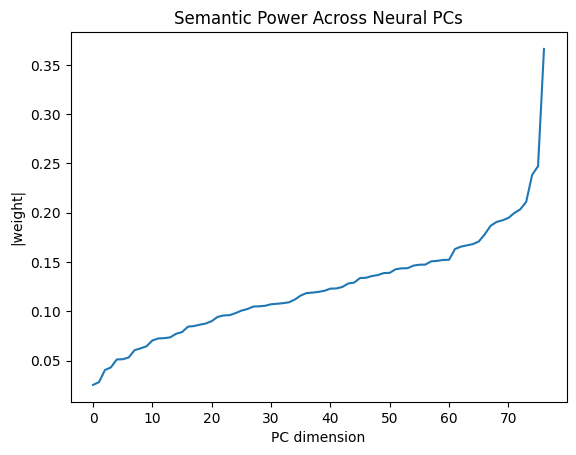

In [30]:
plt.plot(np.sort(mean_power))
plt.xlabel("PC dimension")
plt.ylabel("|weight|")
plt.title("Semantic Power Across Neural PCs")


In [31]:
# all_weights shape = (3 folds, 100 PCs)
mean_power = np.mean(np.abs(all_weights), axis=0)

# sort real PC indices by semantic strength (descending)
sorted_idx = np.argsort(mean_power)[::-1]

print("Top semantic PCs:")
for i in range(10):
    print(f"PC {sorted_idx[i]+1}:  weight={mean_power[sorted_idx[i]]:.4f}")


Top semantic PCs:
PC 1:  weight=0.3661
PC 5:  weight=0.2472
PC 33:  weight=0.2384
PC 55:  weight=0.2110
PC 72:  weight=0.2035
PC 2:  weight=0.1998
PC 26:  weight=0.1948
PC 25:  weight=0.1923
PC 44:  weight=0.1907
PC 13:  weight=0.1867


X shape: (118, 39209)
y shape: (118,)  | proportion animals: 0.5338983050847458


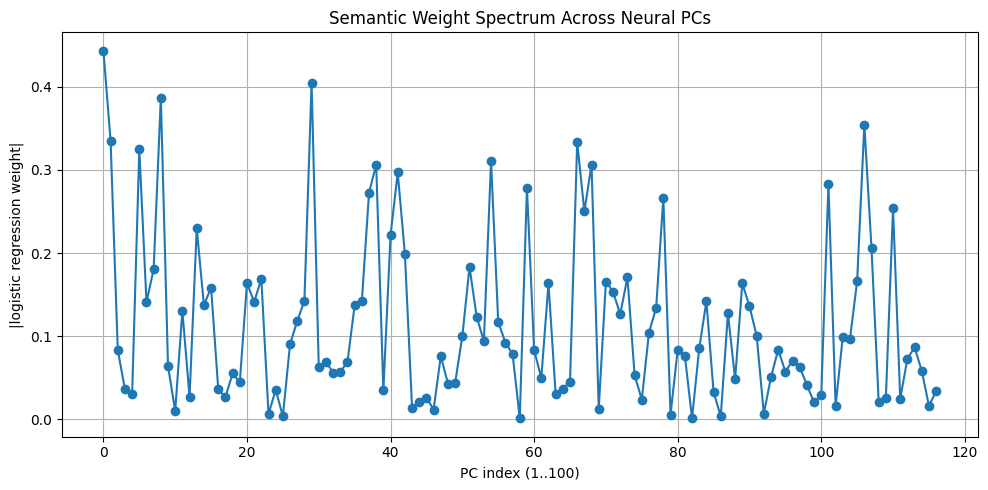


Top semantic PCs (with weights):
PC 1:  |w|=0.4431
PC 30:  |w|=0.4048
PC 9:  |w|=0.3868
PC 107:  |w|=0.3541
PC 2:  |w|=0.3348
PC 67:  |w|=0.3333
PC 6:  |w|=0.3246
PC 55:  |w|=0.3104
PC 39:  |w|=0.3064
PC 69:  |w|=0.3062


In [38]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt

# --------------------------------------------------------
# 1. Data preparation
# --------------------------------------------------------
# R: neurons x images  →  X: images x neurons
X = R.T.astype(float)        # shape (118, 39209)
top1 = np.argmax(vit, axis=1)
y = (top1 <= 397).astype(int)

print("X shape:", X.shape)
print("y shape:", y.shape, " | proportion animals:", y.mean())

# --------------------------------------------------------
# 2. Fit PCA + Logistic on ALL data (analysis-only model)
# --------------------------------------------------------
pca_dim = 117

pipe = Pipeline([
    ("pca", PCA(n_components=pca_dim, svd_solver='randomized')),
    ("clf", LogisticRegression(
        penalty='l2', C=0.1, solver='liblinear', max_iter=500
    ))
])

pipe.fit(X, y)

# Extract components
pca = pipe.named_steps["pca"]
clf = pipe.named_steps["clf"]

weights = clf.coef_[0]           # shape (100,)
abs_weights = np.abs(weights)

# --------------------------------------------------------
# 3. Plot semantic weight spectrum
# --------------------------------------------------------
plt.figure(figsize=(10,5))
plt.plot(abs_weights, marker='o')
plt.title("Semantic Weight Spectrum Across Neural PCs")
plt.xlabel("PC index (1..100)")
plt.ylabel("|logistic regression weight|")
plt.grid(True)
plt.tight_layout()
plt.show()

# Also print ranked PCs
sorted_idx = np.argsort(abs_weights)[::-1]
print("\nTop semantic PCs (with weights):")
for i in range(10):
    print(f"PC {sorted_idx[i]+1}:  |w|={abs_weights[sorted_idx[i]]:.4f}")


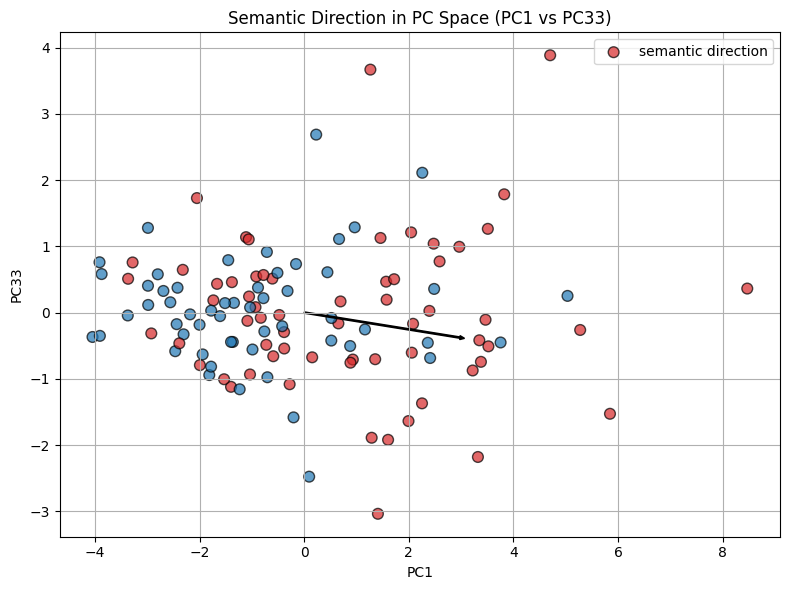

In [39]:
import numpy as np
import matplotlib.pyplot as plt

# ------------------------------------------------------------
# 1. Choose which PCs to visualize
# ------------------------------------------------------------
pc_i = 0     # PC1 (0-indexed)
pc_j = 32    # PC33 (0-indexed)

# ------------------------------------------------------------
# 2. PCA-transformed data (from your final model)
# ------------------------------------------------------------
X_pca = pca.transform(X)          # shape (118, 100)
weights = clf.coef_[0]            # shape (100,)
abs_weights = np.abs(weights)

# semantic direction (full dimensional)
semantic_dir = weights            # sign matters here

# Project semantic direction into the 2D plane (PC_i, PC_j)
semantic_2d = np.array([semantic_dir[pc_i], semantic_dir[pc_j]])

# Normalize for visualization (length doesn’t matter)
semantic_2d = semantic_2d / np.linalg.norm(semantic_2d)

# ------------------------------------------------------------
# 3. Plot
# ------------------------------------------------------------
plt.figure(figsize=(8,6))

# Color points by semantic label (animal = red, inanimate = blue)
colors = ['tab:red' if label == 1 else 'tab:blue' for label in y]

plt.scatter(X_pca[:, pc_i], X_pca[:, pc_j],
            c=colors, alpha=0.7, s=60, edgecolors='k')

# Plot semantic direction vector at the mean point
center = X_pca.mean(axis=0)

plt.arrow(center[pc_i], center[pc_j],
          semantic_2d[0]*3, semantic_2d[1]*3,
          width=0.02, color='black', label='semantic direction')

plt.xlabel(f"PC{pc_i+1}")
plt.ylabel(f"PC{pc_j+1}")
plt.title(f"Semantic Direction in PC Space (PC{pc_i+1} vs PC{pc_j+1})")

plt.grid(True)
plt.legend(["semantic direction"])
plt.tight_layout()
plt.show()


In [40]:
print(X_pca.shape)

(118, 117)


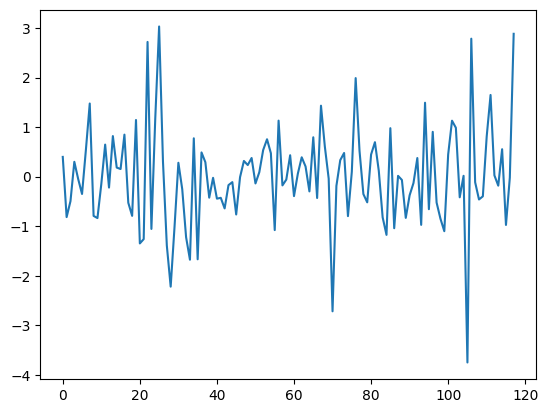

In [45]:
plt.plot(X_pca[:,33])

Top semantic PCs: [  1  30   9 107   2  67   6  55  39]


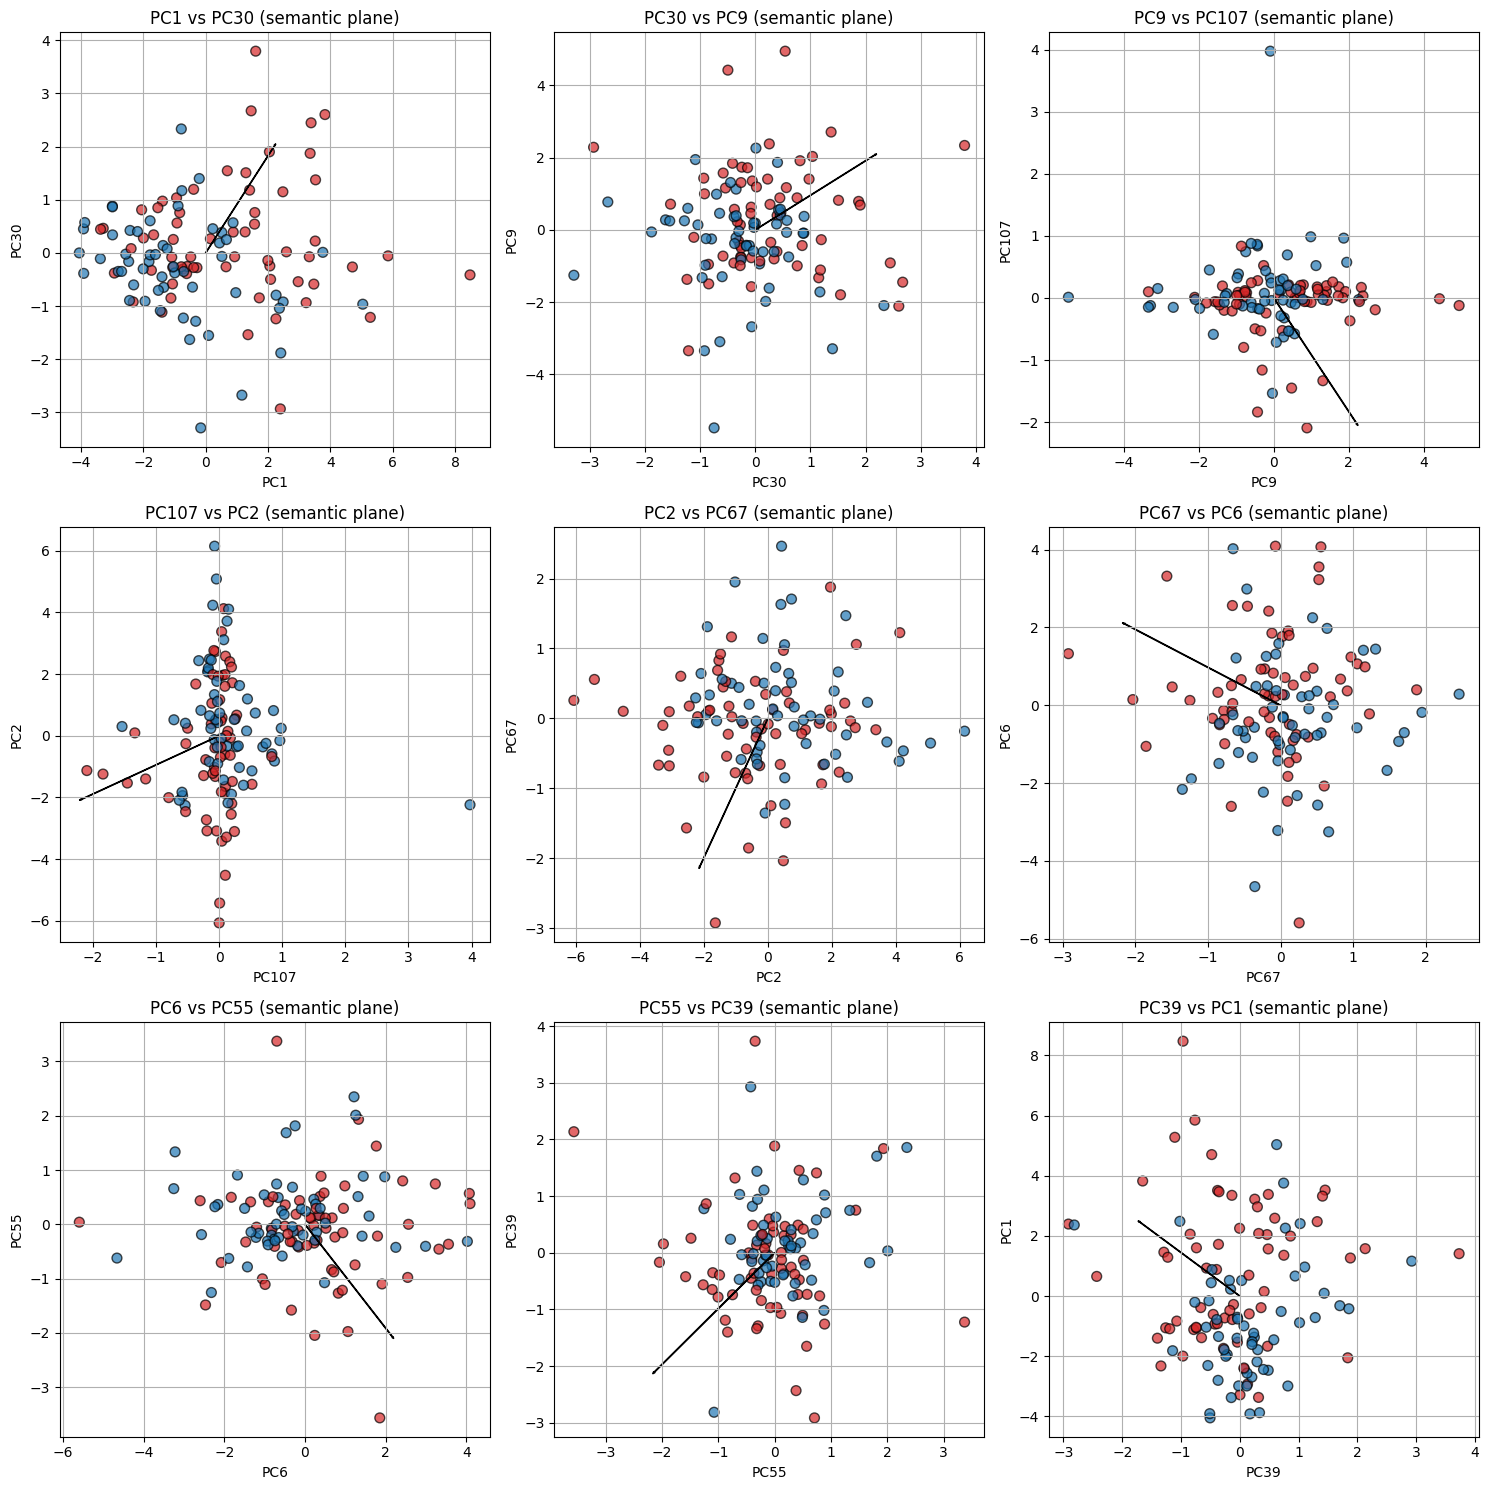

In [46]:
import numpy as np
import matplotlib.pyplot as plt
from math import ceil

# ------------------------------------------------------------
# Inputs assumed from your final model:
# ------------------------------------------------------------
# X_pca = pca.transform(X)        # shape (118, 100)
# weights = clf.coef_[0]          # shape (100,)
# y = (top1 <= 397).astype(int)   # labels
# ------------------------------------------------------------

# 1. Select top semantic PCs
top_k = 9  # change to 6, 9, 12 etc.
abs_w = np.abs(weights)
sorted_idx = np.argsort(abs_w)[::-1]      # largest → smallest
top_pcs = sorted_idx[:top_k]

print("Top semantic PCs:", top_pcs + 1)

# 2. Build grid layout
ncols = 3
nrows = ceil(top_k / ncols)

fig, axes = plt.subplots(nrows, ncols, figsize=(15, 5 * nrows))
axes = axes.flatten()

colors = ['tab:red' if label == 1 else 'tab:blue' for label in y]

# 3. For each top semantic PC, plot PC_i vs next PC
for plot_i, pc_i in enumerate(top_pcs):

    if plot_i >= len(axes):
        break

    ax = axes[plot_i]

    # Choose a second PC (next strongest semantic PC)
    # You can change this pairing logic easily.
    pc_j = top_pcs[(plot_i + 1) % top_k]

    # Scatter plot
    ax.scatter(X_pca[:, pc_i], X_pca[:, pc_j],
               c=colors, s=50, alpha=0.7, edgecolors='k')

    # Project semantic direction into this plane
    semantic_2d = np.array([weights[pc_i], weights[pc_j]])
    if np.linalg.norm(semantic_2d) > 0:
        semantic_2d /= np.linalg.norm(semantic_2d)

        center_i = X_pca[:, pc_i].mean()
        center_j = X_pca[:, pc_j].mean()

        ax.arrow(center_i, center_j,
                 semantic_2d[0] * 3,
                 semantic_2d[1] * 3,
                 width=0.01, color='black')

    ax.set_xlabel(f"PC{pc_i+1}")
    ax.set_ylabel(f"PC{pc_j+1}")
    ax.set_title(f"PC{pc_i+1} vs PC{pc_j+1} (semantic plane)")

    ax.grid(True)

# Remove leftover empty axes
for i in range(top_k, len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()


Top LDA weights:
[  0 110 107 105  89  73  90  78 101  84]


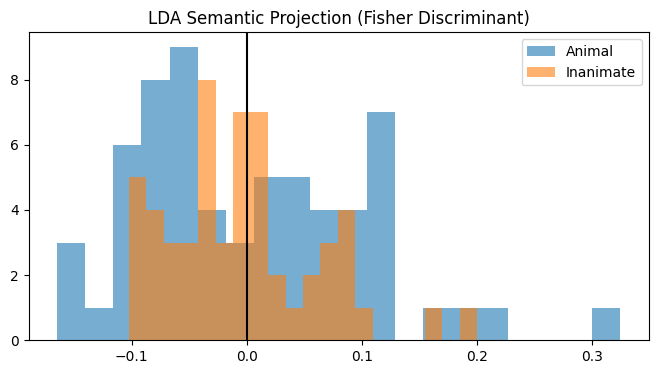

In [47]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# Fit LDA on PCA-reduced data
lda = LinearDiscriminantAnalysis(solver='svd')

X_pca = pca.transform(X)           # from your final model
lda.fit(X_pca, y)

# LDA direction (semantic axis)
w_lda = lda.coef_[0]               # shape (100,)

print("Top LDA weights:")
print(np.argsort(np.abs(w_lda))[::-1][:10])

# Project data along LDA axis
proj = X_pca @ w_lda

# Visualize 1D separation
plt.figure(figsize=(8,4))
plt.hist(proj[y==1], bins=20, alpha=0.6, label='Animal')
plt.hist(proj[y==0], bins=20, alpha=0.6, label='Inanimate')
plt.axvline(proj.mean(), color='k')
plt.legend()
plt.title("LDA Semantic Projection (Fisher Discriminant)")
plt.show()
